In [3]:
from osgeo import gdal,gdal_array
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import tempfile
from math import sqrt,pow

In [1]:
chm = r'\\aitta2.metsakeskus.fi\Aineistot\CHM\Tiedostot\CHM\2021\32bit\Palvelualue_5\Vaasa\P3411G_07062021.tif'
out = r'C:\Users\mkesala\Desktop\Luontokompassi\chmtest5.tif'

In [4]:
def showRaster(raster):
    ds = gdal.Open(raster)
    gt = ds.GetGeoTransform()
    nodata = ds.GetRasterBand(1).GetNoDataValue()
    data = ds.ReadAsArray()
    ds = None
    try:
        data = np.ma.masked_values(data, nodata)
    except:
        data = np.ma.masked_values(data,-9999)
    ys, xs = data.shape
    ulx, xres, _, uly, _, yres = gt
    extent = [ulx, ulx+xres*xs, uly, uly+yres*ys]

    fig, ax = plt.subplots(figsize=(10,10), constrained_layout=True, facecolor='w', dpi=86)

    cmap = mpl.cm.get_cmap("viridis").copy() # cmap = plt.cm.viridis
    cmap.set_bad('#dddddd')

    im = ax.imshow(data, extent=extent, cmap=cmap)
    cb = fig.colorbar(im, shrink=.5)
    cb.set_label('Bathymetry [m]')

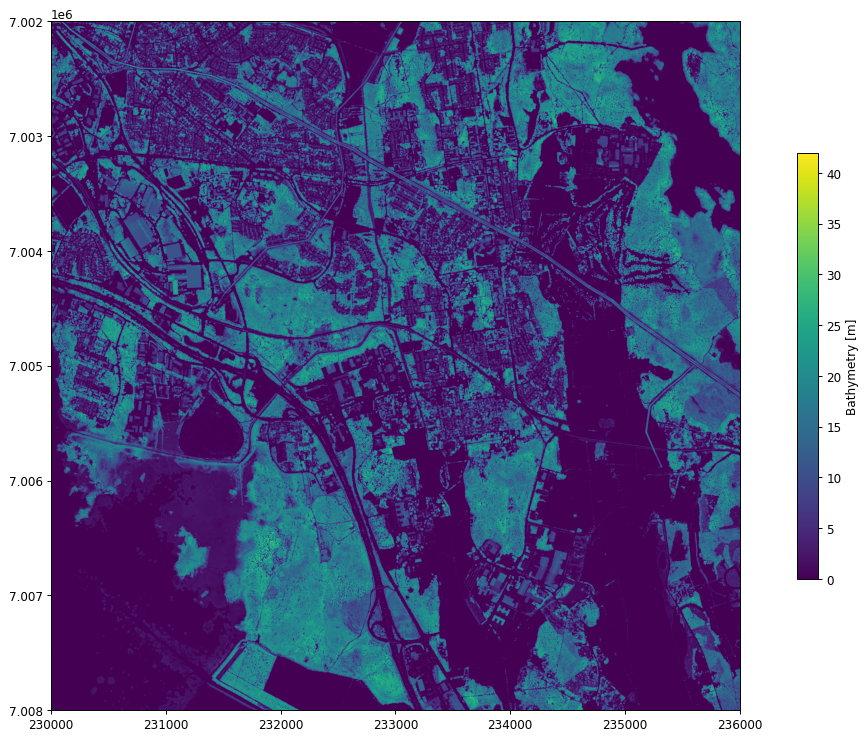

In [5]:
showRaster(chm)

In [6]:
def calcMinimumDirectional(in_array):

    dat =pd.DataFrame(in_array)
    vert = dat
    ijlist = []
    
    df = dat.shift(1,axis=0)
    df1 = df.shift(-1,axis=0)
    
    
    
    for i in range(0-etai,etai):
        for j in range(0-etai,etai):
            e = sqrt(pow(i,2)+pow(j,2))
            if e <=etai:
                ijlist.append((i,j))
    
    for i in ijlist:
        df = dat.shift(1,axis=0)
        df = df.shift(i[1],axis=1)
        vert = pd.concat([vert,df]).max(level=0)
    t = []
    t.append(vert)
    t = np.array(t)

    return t

In [8]:
def dirMinNS(in_array):
    dat =pd.DataFrame(in_array)
    
    df = dat.shift(1,axis=0)
    df1 = dat.shift(-1,axis=0)
    
    vert = pd.concat([dat,df,df1]).min(level=0)
    t=[]
    t.append(vert)
    t = np.array(t)
    return t

In [9]:
def dirMinEW(in_array):
    dat =pd.DataFrame(in_array)
    
    df = dat.shift(1,axis=1)
    df1 = dat.shift(-1,axis=1)
    
    vert = pd.concat([dat,df,df1]).min(level=0)
    t=[]
    t.append(vert)
    t = np.array(t)
    return t

In [10]:
def dirMinNESW(in_array):
    dat =pd.DataFrame(in_array)
    
    df = dat.shift(1,axis=0)
    df = df.shift(1,axis=1)
    
    df1 = dat.shift(-1,axis=0)
    df1 = df1.shift(-1,axis=1)
    
    vert = pd.concat([dat,df,df1]).min(level=0)
    t=[]
    t.append(vert)
    t = np.array(t)
    return t

In [11]:
def dirMinNWSE(in_array):
    dat =pd.DataFrame(in_array)
    
    df = dat.shift(1,axis=0)
    df = df.shift(-1,axis=1)
    
    df1 = dat.shift(-1,axis=0)
    df1 = df1.shift(1,axis=1)
    
    vert = pd.concat([dat,df,df1]).min(level=0)
    t=[]
    t.append(vert)
    t = np.array(t)
    return t

In [12]:
def focalMax(in_array,etai):
    dat =pd.DataFrame(in_array)
    vert = dat
    ijlist = []
    for i in range(0-etai,etai):
        for j in range(0-etai,etai):
            e = sqrt(pow(i,2)+pow(j,2))
            if e <=etai:
                ijlist.append((i,j))
    
    for i in ijlist:
        df = dat.shift(i[0],axis=0)
        df = df.shift(i[1],axis=1)
        vert = pd.concat([vert,df]).max(level=0)
    t = []
    t.append(vert)
    t = np.array(t)

    return t 

In [13]:
def cleanSum(in_array):
    dat =pd.DataFrame(in_array)
    vert = dat
    ijlist = [[1,1],[-1,-1],[1,-1],[-1,1],[1,0],[0,1],[-1,0],[0,-1]]
    
    for i in ijlist:
        df = dat.shift(i[0],axis=0)
        df = df.shift(i[1],axis=1)
        vert = pd.concat([vert,df]).sum(level=0)
    t = []
    t.append(vert)
    t = np.array(t)

    return t 

In [14]:
def raster2Array(in_raster,band):
    rast = gdal.Open(in_raster)
    rastB = rast.GetRasterBand(band)
    rastA = rastB.ReadAsArray()

    return rastA

In [15]:
def array2raster(in_array,map_raster,out):
    if len(out) < 2: 
        tempd = tempfile.TemporaryFile()
        tempd = tempd.name+'.tif'
    else:
        tempd = out
    gdal_array.SaveArray(in_array.astype("float32"),tempd,"GTiff",map_raster)
    #tempd.close()
    return tempd

In [21]:
chm_arr = raster2Array(chm,1)
chm_arr = np.where(chm_arr>1,chm_arr,0)
chm_minNS = dirMinNS(chm_arr)
chm_minEW = dirMinEW(chm_arr)

chm_minNESW = dirMinNESW(chm_arr)
chm_minNWSE = dirMinNWSE(chm_arr)

chm_focalmax = focalMax(chm_arr,3)
minp = np.where(((chm_arr - chm_minNS == 0)|(chm_arr - chm_minEW==0)| (chm_arr - chm_minNESW == 0)|(chm_arr - chm_minNWSE == 0)) & (chm_focalmax-chm_arr!=0),10,1)
clean = cleanSum(minp[0])

minp = np.where(clean>21,minp,1)

#minp
minp = array2raster(minp,chm,out)
#showRaster(minp)

In [26]:
chm_arr

array([[ 0.153,  0.153,  6.23 , ..., 21.536, 20.546, 19.342],
       [ 0.   ,  6.23 ,  6.255, ..., 18.815, 18.815, 18.084],
       [ 0.091,  0.   ,  6.71 , ..., 19.642, 19.642, 19.882],
       ...,
       [ 0.   ,  0.   ,  0.   , ..., 10.08 , 12.407, 13.569],
       [ 0.   ,  0.   ,  0.   , ..., 11.15 , 11.927, 13.569],
       [ 0.   ,  0.   ,  0.   , ..., 11.017, 12.287, 13.186]],
      dtype=float32)

In [18]:
test_arr = [[1,3,2,1,3],
           [2,1,2,1,2],
           [3,3,1,3,3],
           [4,1,4,4,4],
           [5,5,1,5,5]]
test_arr = np.array(test_arr)
test_arr

array([[1, 3, 2, 1, 3],
       [2, 1, 2, 1, 2],
       [3, 3, 1, 3, 3],
       [4, 1, 4, 4, 4],
       [5, 5, 1, 5, 5]])

In [19]:
clean = cleanSum(test_arr)
clean

array([[[ 7., 11., 10., 11.,  7.],
        [13., 18., 17., 18., 13.],
        [14., 21., 20., 24., 17.],
        [21., 27., 27., 30., 24.],
        [15., 20., 20., 23., 18.]]])

In [34]:
dat =pd.DataFrame(test_arr)
tests = dat.shift(1,axis=1,fill_value=9999)
tests

,0,1,2,3,4
0,1,1,1,1,9999
1,2,2,2,2,9999
2,3,3,3,3,9999
3,4,4,4,4,9999
4,5,5,5,5,9999


In [22]:
print (chm_arr.ndim)

2


In [40]:
if len(test) < 2:
    print ("jjj")
else:
    print ("jaa")

jjj
